In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import pickle
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from stop_words import get_stop_words
import gensim
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import random
import tqdm

In [4]:
df = pd.read_csv('corpus.csv')
print(df.shape)
df.head()

(4432, 4)


,Article_id,Title,Content,url
0,0,"TVs, Tablets And Phones: How To Manage 'Screen...",In today’s media-rich world (or media-saturate...,https://www.ibtimes.com/tvs-tablets-phones-how...
1,1,Firefighters Warn Hand Sanitizers Left Inside ...,KEY POINTS Fire fighters warn that hand saniti...,https://www.ibtimes.com/firefighters-warn-hand...
2,2,Hand Sanitizers: Do They Go Out Of Date?,KEY POINTS Coronavirus confirmed cases around ...,https://www.ibtimes.com/hand-sanitizers-do-the...
3,3,Coronavirus Update: SpaceX Is Creating Hand Sa...,KEY POINTS SpaceX is making face shields and h...,https://www.ibtimes.com/coronavirus-update-spa...
4,4,Trump Says US Won't Close If Hit By Coronaviru...,KEY POINTS Trump will not shut down America ag...,https://www.ibtimes.com/trump-says-us-wont-clo...


In [5]:
df = df[['Article_id', 'Title', 'Content']].dropna()
df = df.drop_duplicates(keep='first')
df.shape

(4427, 3)

In [6]:
texts=[] # Define an array for holding the relevant words in each documents

# Now, change the content column of the dataframe to a list
content = df['Content'].tolist()

# Define the common stop words in english using the stop_words library
en_stop = get_stop_words('en')
# Define other words or letters that may be repetitive/irrelevant
letters = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z"]
other = ["wa","ha","one","two","id","re","http","com","mr","image","photo","caption","don","sen","pic","co",
         "source","watch","play","duration","video","momentjs","getty","images","newsletter", "story", "go", "like", "say",
         "will", "just", "today", "can", "year", "make", "view", "read","said", "also"]

# Define the stemmer
stemmer = SnowballStemmer("english")

# Select each doocument separately and perform preprocessing
for i in range(len(content)):
    doc = content[i]

    doc = doc.replace("\n"," ")
    doc = doc.replace("\'","")

    doc = gensim.utils.simple_preprocess(doc)
    
    # Lemmatize the document
    doc = [stemmer.stem(WordNetLemmatizer().lemmatize(word, pos='v')) for word in doc]
    
    # Remove stop words
    doc = [word for word in doc if not word in (en_stop+letters+other)]
    
    texts.append(doc)

We now split the pre-processed corpus into training and testing data sets

In [7]:
random.seed(75) # For reproducibility
train_indices = random.sample(list(range(0,len(texts))),len(texts)-1000)
test_indices = [x for x in list(range(0,len(texts))) if x not in train_indices]

train_data = [texts[i] for i in train_indices]
test_data = [texts[i] for i in test_indices]

In [8]:
dictionary = gensim.corpora.Dictionary(train_data)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in train_data]

In [7]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=50)

# for i in ldamodel.print_topics(num_topics=3, num_words=10):
#     print(i)

print('\nPerplexity: ', ldamodel.log_perplexity(doc_term_matrix))

from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=ldamodel, texts= train_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

def compute_coherence_values(dictionary, doc_term_matrix, cleaned_articles, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = Lda(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=train_data, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(cleaned_articles,start, stop, step):
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,cleaned_articles,
                                                            stop, start, step)
    print(model_list)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()


Perplexity:  -8.19349799384252

Coherence Score:  0.47386953287027983


[<gensim.models.ldamodel.LdaModel object at 0x0000004C4EAB7978>, <gensim.models.ldamodel.LdaModel object at 0x0000004C4C24E240>, <gensim.models.ldamodel.LdaModel object at 0x0000004C5736A630>, <gensim.models.ldamodel.LdaModel object at 0x0000004C65A8CDD8>, <gensim.models.ldamodel.LdaModel object at 0x0000004C65A8FDD8>, <gensim.models.ldamodel.LdaModel object at 0x0000004C65A7CCF8>, <gensim.models.ldamodel.LdaModel object at 0x0000004C65A7C128>, <gensim.models.ldamodel.LdaModel object at 0x0000004C65A7ECF8>, <gensim.models.ldamodel.LdaModel object at 0x0000004C65A708D0>, <gensim.models.ldamodel.LdaModel object at 0x0000004C65A5F390>, <gensim.models.ldamodel.LdaModel object at 0x0000004C65A809E8>, <gensim.models.ldamodel.LdaModel object at 0x0000004C65A79320>, <gensim.models.ldamodel.LdaModel object at 0x0000004C65A58CC0>, <gensim.models.ldamodel.LdaModel object at 0x0000004C65A79C88>, <gensim.models.ldamodel.LdaModel object at 0x0000004C4EAB7940>, <gensim.models.ldamodel.LdaModel object

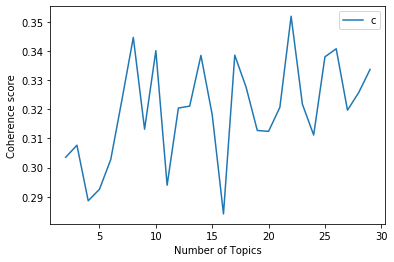

In [8]:
start,stop,step=2,30,1
plot_graph(train_data,start,stop,step)

In [9]:
ldamodel = Lda(doc_term_matrix, num_topics=20, id2word = dictionary, passes=50)

In [10]:
ldamodel.print_topics()

[(0,
  '0.012*"polic" + 0.007*"famili" + 0.006*"report" + 0.006*"alleg" + 0.005*"princ" + 0.005*"investig" + 0.005*"old" + 0.005*"time" + 0.005*"arrest" + 0.005*"kill"'),
 (1,
  '0.005*"facebook" + 0.005*"move" + 0.005*"app" + 0.004*"well" + 0.004*"get" + 0.004*"share" + 0.004*"rb" + 0.004*"huawei" + 0.004*"hair" + 0.004*"top"'),
 (2,
  '0.012*"bengal" + 0.011*"cyclon" + 0.010*"cbd" + 0.008*"storm" + 0.008*"west" + 0.008*"bangladesh" + 0.008*"day" + 0.007*"us" + 0.006*"india" + 0.006*"peopl"'),
 (3,
  '0.021*"water" + 0.008*"gas" + 0.007*"rs" + 0.007*"suppli" + 0.006*"state" + 0.006*"project" + 0.005*"power" + 0.005*"energi" + 0.004*"iphon" + 0.004*"india"'),
 (4,
  '0.010*"polic" + 0.007*"oper" + 0.006*"offici" + 0.006*"state" + 0.006*"road" + 0.006*"forc" + 0.005*"area" + 0.005*"district" + 0.004*"includ" + 0.004*"take"'),
 (5,
  '0.016*"film" + 0.010*"game" + 0.007*"new" + 0.006*"releas" + 0.006*"special" + 0.006*"star" + 0.006*"taiwan" + 0.006*"fan" + 0.006*"train" + 0.005*"reveal"

In [11]:
import itertools
lda_corpus = ldamodel[doc_term_matrix]

scores = list(itertools.chain(*[[score for topic_id,score in topic] \
                     for topic in [doc for doc in lda_corpus]]))

threshold = sum(scores)/len(scores)
print(threshold)

cluster1 = [j for i,j in zip(lda_corpus,train_data) if i[0][1] > threshold]

print(cluster1)

0.2241800239537715


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
# cluster1 = [j for i,j in zip(lda_corpus,documents) if i[0][1] > threshold]
# cluster2 = [j for i,j in zip(lda_corpus,documents) if i[1][1] > threshold]
# cluster3 = [j for i,j in zip(lda_corpus,documents) if i[2][1] > threshold]


# Generating user profile

For the user profile, we need a variety of data, of which time spent on an article and the time of clicking an article is the most important. The dataframe should also contain article id and number of times an article was read by other users. 

Since we need a sparse user-article matrix at the end with time spend by users on its entries, we can use sparse function in scikit-learn. This function can generate sparse values from any random distribution, which in our case would be a multinomial distribution.

In [9]:
import scipy.sparse as sp
import scipy.stats as ss

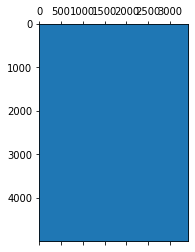

In [10]:
n_users = 5000
n_articles = len(train_data)
random.seed(5)
A = sp.random(n_users, n_articles, density=0.045, data_rvs = np.ones)
plt.spy(A,markersize = 1)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1, 0)


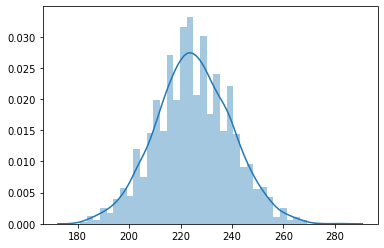

In [11]:
print(A.toarray())
n_reads = np.sum(A, axis = 0)
print(n_reads[n_reads==0].shape)
sns.distplot(n_reads)

(1, 0)


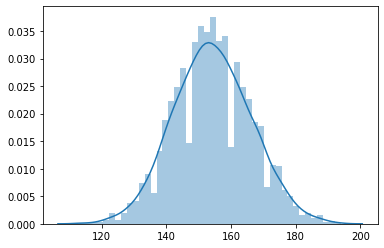

In [12]:
n_user_reads = np.sum(A, axis = 1)
sns.distplot(n_user_reads)
print(n_user_reads[n_user_reads==0].shape)

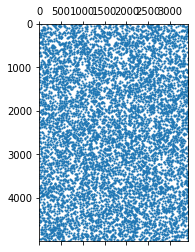

In [13]:
random.seed(5)
A = sp.random(n_users, n_articles, density=0.0005)
plt.spy(A,markersize = 1)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1, 273)


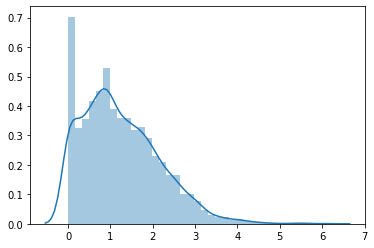

In [14]:
print(A.toarray())
n_reads = np.sum(A, axis = 0)
print(n_reads[n_reads==0].shape)
sns.distplot(n_reads)

(1, 879)


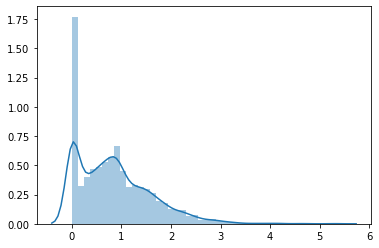

In [15]:
n_user_reads = np.sum(A, axis = 1)
sns.distplot(n_user_reads)
print(n_user_reads[n_user_reads==0].shape)

[13.04760006 13.8462024  16.17336528 ... 26.7926707  20.57133738
 19.47581617]


C:\Users\Sasidharan\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


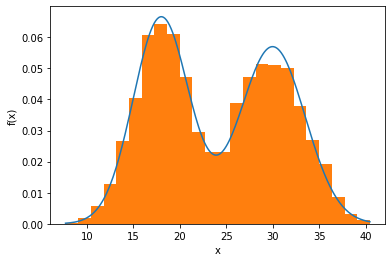

In [16]:
random.seed(5)
norm_params = np.array([[18, 3],
                        [30, 3.5],])
n_components = norm_params.shape[0]
# Weight of each component, in this case all of them are 1/2
weights = np.ones(n_components, dtype=np.float64) / float(n_components)
# A stream of indices from which to choose the component
mixture_idx = np.random.choice(n_components, size=n_users, replace=True, p=weights)
# y is the mixture sample
y = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx),
                   dtype=np.float64)

print(y)
# Theoretical PDF plotting -- generate the x and y plotting positions
xs = np.linspace(y.min(), y.max(), 200)
ys = np.zeros_like(xs)

for (l, s), w in zip(norm_params, weights):
    ys += ss.norm.pdf(xs, loc=l, scale=s) * w

plt.plot(xs, ys)
plt.hist(y, normed=True, bins="fd")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

  (0, 153)	24.515941667741906
  (0, 323)	25.66179191111172
  (0, 407)	21.11253625133459
  (0, 478)	22.63271192669839
  (0, 540)	19.164124867109603
  (0, 599)	23.82295975528899
  (0, 699)	21.36600513305569
  (0, 764)	21.40353487765546
  (0, 841)	20.00703845897186
  (0, 947)	24.32793007798064
  (0, 980)	25.90787095403666
  (0, 1070)	27.07843762124621
  (0, 1095)	26.89020157926749
  (0, 1146)	23.456966392636122
  (0, 1161)	22.01995271759977
  (0, 1197)	23.409644496344328
  (0, 1359)	21.393047558416928
  (0, 1376)	23.18305346129576
  (0, 1386)	22.974647937864667
  (0, 1391)	22.333469489230936
  (0, 1392)	23.485811190134974
  (0, 1440)	20.201616068219753
  (0, 1500)	25.787055581963205
  (0, 1523)	22.968640957915643
  (0, 1579)	22.273567728201332
  :	:
  (4999, 562)	25.54061022030119
  (4999, 725)	22.855884636265365
  (4999, 781)	27.395120052491887
  (4999, 863)	22.30990201438209
  (4999, 908)	21.68709545823547
  (4999, 939)	23.88150741452082
  (4999, 1205)	25.93067315863958
  (4999, 1226)	2

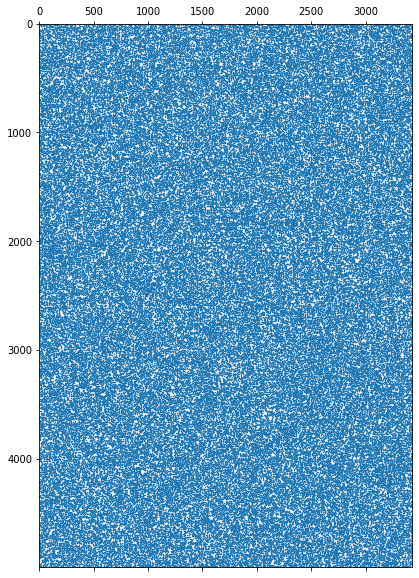

In [72]:
A1 = sp.random(n_users, n_articles, density=0.01, random_state = 311, \
               data_rvs = ss.norm(*(norm_params[0])).rvs)
B = sp.random(n_users, n_articles, density=0.01, random_state = 311, \
              data_rvs = ss.norm(*(norm_params[1])).rvs)
A = 0.5*A1+0.5*B
print(A)
plt.rcParams["figure.figsize"] = [7,10]
plt.spy(A,markersize = 0.5)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1, 0)


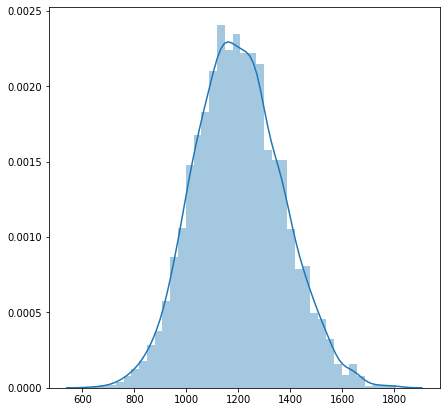

In [58]:
print(A.toarray())
n_reads = np.sum(A, axis = 0)
print(n_reads[n_reads==0].shape)
sns.distplot(n_reads)

(1, 0)


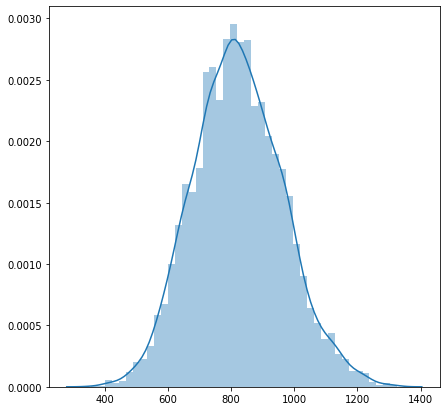

In [59]:
n_user_reads = np.sum(A, axis = 1)
sns.distplot(n_user_reads)
print(n_user_reads[n_user_reads==0].shape)

In [60]:
names = []
for i in range(n_articles):
    names.append(str(i))
index = []
for i in range(n_users):
    index.append('U'+str(i+1))
df_user = pd.DataFrame(A.todense(), columns = names, index = index)
df_user.head()

,0,1,2,3,4,5,6,7,8,9,...,3417,3418,3419,3420,3421,3422,3423,3424,3425,3426
U1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
df_user['User_id'] = df_user.index
df_user.head()

,0,1,2,3,4,5,6,7,8,9,...,3418,3419,3420,3421,3422,3423,3424,3425,3426,User_id
U1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,U1
U2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,U2
U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,U3
U4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,U4
U5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,U5


In [62]:
cols = df_user.columns.tolist()
cols.insert(0, cols.pop(cols.index('User_id')))
df_user = df_user.reindex(columns= cols)
df_user.head()

,User_id,0,1,2,3,4,5,6,7,8,...,3417,3418,3419,3420,3421,3422,3423,3424,3425,3426
U1,U1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U2,U2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U3,U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U4,U4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U5,U5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
user_profile = pd.melt(df_user, id_vars = ['User_id'], value_vars = names, var_name = 'Article_id', value_name = 'Time_spent')
user_profile.head()

,User_id,Article_id,Time_spent
0,U1,0,0.0
1,U2,0,0.0
2,U3,0,0.0
3,U4,0,0.0
4,U5,0,0.0


In [64]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(A, A)
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.02446775, ..., 0.        , 0.02572189,
        0.        ],
       [0.        , 0.02446775, 1.        , ..., 0.        , 0.        ,
        0.03354828],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.04048655],
       [0.        , 0.02572189, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.03354828, ..., 0.04048655, 0.        ,
        1.        ]])

In [33]:
#Convert into pandas dataframe 
cosine_sim = pd.DataFrame(cosine_sim, index=index, columns=index)

cosine_sim.head(10)

,U1,U2,U3,U4,U5,U6,U7,U8,U9,U10,...,U4991,U4992,U4993,U4994,U4995,U4996,U4997,U4998,U4999,U5000
U1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
from sklearn.neighbors import NearestNeighbors

In [77]:
model_knn = NearestNeighbors(metric='cosine', algorithm ='brute')
model_knn.fit(A)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [88]:
query_index = 150
distances, indices = model_knn.kneighbors(df_user.iloc[query_index,1:]\
                     .values.reshape(1, -1),n_neighbors = 6)

In [87]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(df.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, \
                    df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for 151:

1: 3384, with distance of 0.8908964788002719:
2: 2662, with distance of 0.8924918797217133:
3: 893, with distance of 0.8983704340447768:
4: 3657, with distance of 0.8986178161935938:
5: 3620, with distance of 0.9001044145617013:
